In [1]:
import pandas as pd
import numpy as np

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, KBinsDiscretizer, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
# from sklearn.

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

### Removing Null values

In [4]:
train_data=train_data.dropna(how='any')

### Adding New Columns

In [5]:
def add_features(X):
    X['Date']=pd.to_datetime(X['CreationTimestamp'], unit='s')
    X['Day']=X['Date'].dt.day_name()
    X['Hour']=X['Date'].apply(lambda x: x.hour + x.minute/60)
    X['ThumbsDifference']=X['ThumbsUpCount']-X['ThumbsDownCount']
    return X

train_data=add_features(train_data)
test_data=add_features(test_data)

### Cleaning Text Features

In [7]:
def clean_text(X):
    replace_dict={'&#34;': '"', '&#39;': "'", '&amp;': 'and', '&gt;': '', '&lt;': ''}
    cleaned=X['Recipe_Review'].str.replace('&.*?;', lambda match: replace_dict[match.group()], regex=True)
    cleaned=cleaned.str.replace(r"'\w+?", "", regex=True)
    X['Recipe_Review']=cleaned
    return X

train_data=clean_text(train_data)
test_data=clean_text(test_data)

In [10]:
train_data=train_data[train_data['ThumbsDifference'] > -75]

In [11]:
train_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review', 'Date', 'Day', 'Hour', 'ThumbsDifference'],
      dtype='object')

### Dividing data into train and validation

In [13]:
X, y=train_data.drop('Rating', axis=1), train_data['Rating']
X_test=test_data

In [14]:
X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, random_state=29)

In [15]:
PolynomialFeatures(include_bias=False, degree=3, interaction_only=True).fit(X_train[['RecipeNumber', 'UserReputation',
                                                    'ReplyCount', 'ThumbsUpCount',
                                                    'ThumbsDownCount', 'BestScore']], y_train).n_output_features_

41

### Pipeline

In [90]:
# col_transform=ColumnTransformer([('poly', PolynomialFeatures(include_bias=False, degree=3, interaction_only=True), ['RecipeNumber', 'UserReputation',
#                                                              'ReplyCount', 'ThumbsUpCount',
#                                                              'ThumbsDownCount', 'BestScore']),
#                                 #  ('day_encode', OneHotEncoder(), ['Day']),
#                                  ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
#                                                                   strategy='quantile', random_state=29, subsample=None),
#                                                                   ['Hour']),
#                                  ('vectorizer', CountVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])
# scaler=ColumnTransformer([('scaler', StandardScaler(), list(range(41)))],
#                          remainder='passthrough')

# weights={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5, 5: 1.8}
# pipeline=Pipeline([('col_transform', col_transform),
#                    ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
#                    ('scaler', scaler),
#                    ('clsf', LogisticRegression(class_weight=weights, penalty='l2', #penalty='elasticnet', 
#                                                C=0.015, multi_class='multinomial', solver='lbfgs', #solver='saga', l1_ratio=0,
#                                                max_iter=200, n_jobs=-1))])

col_transform=ColumnTransformer([('scaler', StandardScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'ThumbsDifference', 'BestScore']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                  strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', TfidfVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])

weights={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5, 5: 1.8}
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', LogisticRegression(penalty='l2', multi_class='multinomial',
                                               solver='lbfgs', max_iter=300, C=0.7))])

In [91]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'ThumbsDifference',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  TfidfVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x0000028F808FD1B0>)),
                ('clsf',
                 LogisticRegression(max_iter=300, multi_class='multinomial'))])

### Train Report

In [95]:
train_predict=pipeline.predict(X_train)

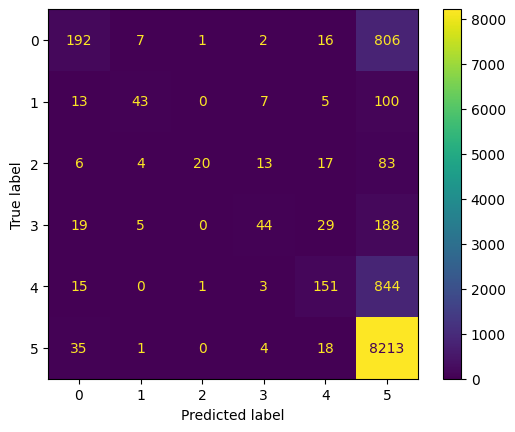

In [96]:
ConfusionMatrixDisplay.from_predictions(y_train, train_predict, display_labels=pipeline.classes_);

In [97]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.69      0.19      0.29      1024
           1       0.72      0.26      0.38       168
           2       0.91      0.14      0.24       143
           3       0.60      0.15      0.25       285
           4       0.64      0.15      0.24      1014
           5       0.80      0.99      0.89      8271

    accuracy                           0.79     10905
   macro avg       0.73      0.31      0.38     10905
weighted avg       0.77      0.79      0.74     10905



In [98]:
accuracy_score(y_train, train_predict)

0.7944062356717102

### Test Report

In [99]:
valid_predict=pipeline.predict(X_valid)

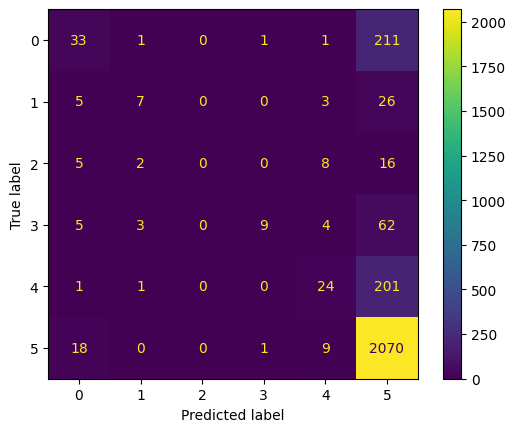

In [100]:
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);

In [104]:
print(classification_report(y_valid, valid_predict, zero_division=0))

              precision    recall  f1-score   support

           0       0.49      0.13      0.21       247
           1       0.50      0.17      0.25        41
           2       0.00      0.00      0.00        31
           3       0.82      0.11      0.19        83
           4       0.49      0.11      0.17       227
           5       0.80      0.99      0.88      2098

    accuracy                           0.79      2727
   macro avg       0.52      0.25      0.29      2727
weighted avg       0.73      0.79      0.72      2727



In [102]:
accuracy_score(y_valid, valid_predict)

0.7858452511917858

### Grid Search

In [94]:
gscv=GridSearchCV(pipeline, param_grid={'clsf__C' : [0.6, 0.65, 0.7, 0.75, 0.8]}, cv=4, n_jobs=-1)
gscv.fit(X_train, y_train)
gscv.best_params_, gscv.best_score_

({'clsf__C': 0.7}, 0.7668961320196583)

### Training on whole dataset

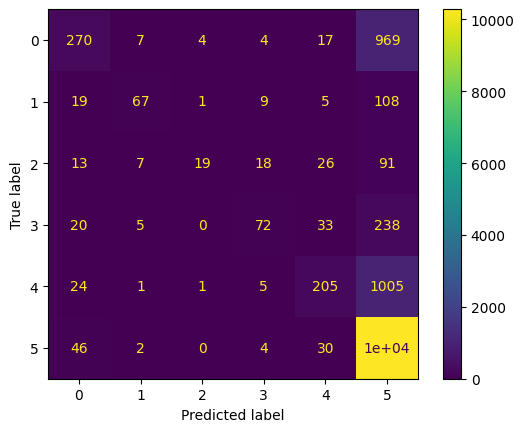

In [105]:
pipeline.fit(X, y)
whole_predict=pipeline.predict(X)
ConfusionMatrixDisplay.from_predictions(y, whole_predict, display_labels=pipeline.classes_);

In [107]:
print(classification_report(y, whole_predict))

              precision    recall  f1-score   support

           0       0.69      0.21      0.32      1271
           1       0.75      0.32      0.45       209
           2       0.76      0.11      0.19       174
           3       0.64      0.20      0.30       368
           4       0.65      0.17      0.26      1241
           5       0.81      0.99      0.89     10369

    accuracy                           0.80     13632
   macro avg       0.72      0.33      0.40     13632
weighted avg       0.78      0.80      0.75     13632



In [108]:
accuracy_score(y, whole_predict)

0.801056338028169

In [338]:
test_predict=pipeline.predict(X_test)